In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Reshape,InputLayer

In [7]:
train = pd.read_csv('Datasets\9 Credit Card Dataset\creditcard.csv')

In [8]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [25]:
#train['Class'].nunique()
print(f"The normal class has {train[train['Class'] == 0].shape[0]} samples")
print(f"The anomaly class has {train[train['Class'] == 1].shape[0]} samples")


The normal class has 284315 samples
The anomaly class has 492 samples


In [9]:
# Separate features and labels
X = train.drop("Class", axis=1).values
y = train["Class"].values

In [10]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
# Split into training data (only normal) and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"The train_x :{X_train.shape}")
print(f"The train_y :{y_train.shape}")
print(f"The test_X :{X_test.shape}")
print(f"The test_y :{y_test.shape}")

The train_x :(227845, 30)
The train_y :(227845,)
The test_X :(56962, 30)
The test_y :(56962,)


In [12]:
# Use only the normal (Class 0) data for training
X_train_normal = X_train[y_train == 0]


In [26]:
# Define the Autoencoder model
model = Sequential([
    #Encoder Part
    Dense(16, activation='relu', input_shape=(X.shape[1],)),
    Dense(8, activation='relu'),
    #Decoder Part
    Dense(16, activation='relu'),
    Dense(X.shape[1], activation='sigmoid')  # Output layer matches the input shape
])

model.compile(optimizer='adam', loss='mse')

In [28]:
# Train the model on normal data only
history = model.fit(X_train_normal, X_train_normal, 
                    epochs=5, 
                    batch_size=32, 
                    validation_split=0.1, 
                    shuffle=True)

Epoch 1/5
6398/6398 [==============================] - 18s 3ms/step - loss: 0.7715 - val_loss: 0.7540
Epoch 2/5
6398/6398 [==============================] - 18s 3ms/step - loss: 0.7576 - val_loss: 0.7449
Epoch 3/5
6398/6398 [==============================] - 18s 3ms/step - loss: 0.7508 - val_loss: 0.7404
Epoch 4/5
6398/6398 [==============================] - 18s 3ms/step - loss: 0.7473 - val_loss: 0.7373
Epoch 5/5
6398/6398 [==============================] - 18s 3ms/step - loss: 0.7444 - val_loss: 0.7340


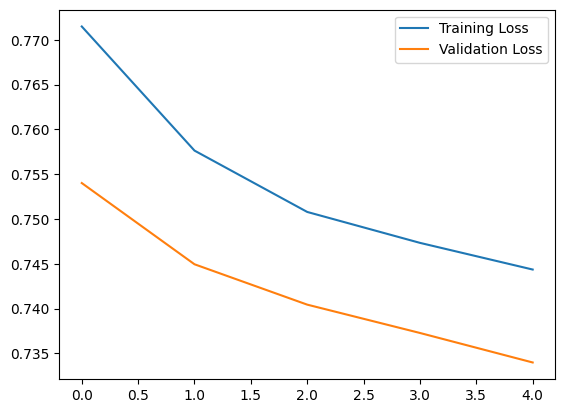

In [29]:
# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Calculate reconstruction error for the test set
X_test_pred = model.predict(X_test)
#The Below Reconstruction_error is same as mse
reconstruction_errors = np.mean(np.square(X_test_pred - X_test), axis=1)

1781/1781 [==============================] - 4s 2ms/step


In [32]:
# Set a threshold for anomaly detection based on training reconstruction error
threshold = np.percentile(reconstruction_errors, 95)  # 95th percentile

In [33]:
# Flag transactions with reconstruction error above the threshold as anomalies
y_pred = (reconstruction_errors > threshold).astype(int)

Confusion Matrix:
[[54103  2761]
 [   10    88]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56864
           1       0.03      0.90      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.92      0.52     56962
weighted avg       1.00      0.95      0.97     56962



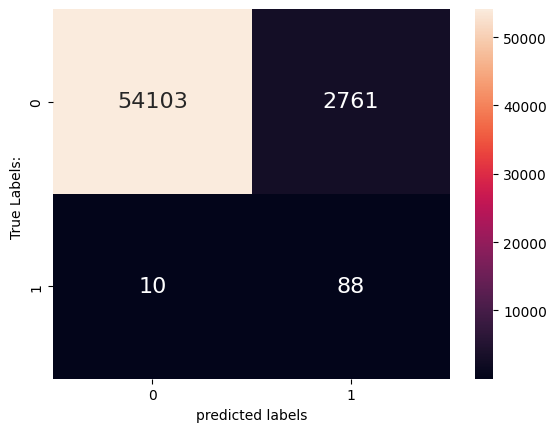

In [38]:
# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True, annot_kws = {"size": 16}, fmt = 'd')
plt.xlabel("predicted labels")
plt.ylabel("True Labels: ")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))